In [37]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/EC523Project"
#!ls "/content/drive/Shared with me/EC523Project"

 Augmented_data				     lits_df.csv
 Augmented_data_original+3transforms	     lits_probe.csv
 AutoLiverCancerDetection.ipynb		     lits_test.csv
 AutoLiverCancerDetection_transUnet.ipynb    lits_train.csv
'Copy of EC 523 Project Proposal (1).gdoc'   Liver_Tumor
'Copy of EC 523 Project Proposal.gdoc'	    'Resize_augmented(512x512x512)'
 Dang_UNet++.ipynb			     SegmentationData
'EC 523 Project.gdoc'			     VolumeData
'EC 523 Project Proposal.gdoc'


# Load Data

In [3]:
import os
import glob
import cv2
import imageio

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [4]:
# Define the path to the segmentation data directory in Google Drive
segmentation_data_path = "/content/drive/My Drive/EC523Project/SegmentationData/segmentations"
#segmentation_data_path = "/content/drive/Shared with me/EC523Project/SegmentationData/segmentations"

# Define the path to the volume data directory in Google Drive
volume_data_path = "/content/drive/My Drive/EC523Project/VolumeData"
#volume_data_path = "/content/drive/Shared with me/EC523Project/VolumeData"

In [5]:
# Retrieve all .nii file paths from the segmentation_data_path
segmentation_files = [os.path.join(segmentation_data_path, f) for f in os.listdir(segmentation_data_path) if f.endswith('.nii')]

# Extract directory names and filenames from the segmentation file paths
segmentation_dirnames = [os.path.dirname(f) for f in segmentation_files]
segmentation_filenames = [os.path.basename(f) for f in segmentation_files]

# Create a DataFrame with the directory and filename information
segmentation_df = pd.DataFrame({
    'dirname': segmentation_dirnames,
    'filename': segmentation_filenames
})

# Sort the DataFrame based on filename in ascending order
segmentation_df = segmentation_df.sort_values(by=['filename'], ascending=True)

# Display the segmentation DataFrame
print("Segmentation Files:")
print(segmentation_df)

Segmentation Files:
                                                                 dirname  \
0    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
1    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
2    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
3    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
4    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
..                                                                   ...   
126  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
127  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
128  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
129  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
130  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   

                 filename  
0      segmentation-0.nii  
1      segm

In [6]:
# Initialize an empty list to store volume file paths
volume_files = []

# Iterate over each folder in the volume data path
for pt_folder in os.listdir(volume_data_path):
    pt_folder_path = os.path.join(volume_data_path, pt_folder)

    # Check if the current path is a directory
    if os.path.isdir(pt_folder_path):
        # Iterate over each file in the directory
        for volume_file in os.listdir(pt_folder_path):
            # If the file is a .nii file, append its path to the volume_files list
            if volume_file.endswith('.nii'):
                volume_files.append(os.path.join(pt_folder_path, volume_file))

# Extract directory names and filenames from the volume file paths
volume_dirnames = [os.path.dirname(f) for f in volume_files]
volume_filenames = [os.path.basename(f) for f in volume_files]

# Create a DataFrame with the directory and filename information
volume_df = pd.DataFrame({
    'dirname': volume_dirnames,
    'filename': volume_filenames
})

# Sort the DataFrame based on filename in ascending order
volume_df = volume_df.sort_values(by=['filename'], ascending=True)

# Display the volume DataFrame
print("\nVolume Files:")
print(volume_df)



Volume Files:
                                                        dirname  \
0    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
1    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
2    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
81   /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
51   /content/drive/My Drive/EC523Project/VolumeData/volume_pt8   
..                                                          ...   
126  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
127  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
128  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
129  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
130  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   

           filename  
0      volume-0.nii  
1      volume-1.nii  
2     volume-10.nii  
81   volume-100.nii  
51   volume-101.nii  
..              ...  
126   volume-95.nii  
127 

In [7]:
# Combine segmentation_df and volume_df into a consolidated DataFrame
df_files = pd.concat([segmentation_df, volume_df], ignore_index=True)

# Create new columns to store mask directory and filename
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

# Assuming you have 131 pairs of CT scans and their corresponding segmentations
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    # Update mask_filename and mask_dirname where the filename matches the CT scan
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = segmentation_data_path

# Filter out rows that don't have a corresponding mask
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

# Display the final DataFrame
df_files


,dirname,filename,mask_dirname,mask_filename
0,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-0.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-0.nii
1,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-1.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-1.nii
2,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-10.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-10.nii
3,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-100.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-100.nii
4,/content/drive/My Drive/EC523Project/VolumeData/volume_pt8,volume-101.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-101.nii
...,...,...,...,...
126,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-95.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-95.nii
127,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-96.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-96.nii
128,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-97.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-97.nii
129,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-98.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-98.nii


In [8]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [10]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


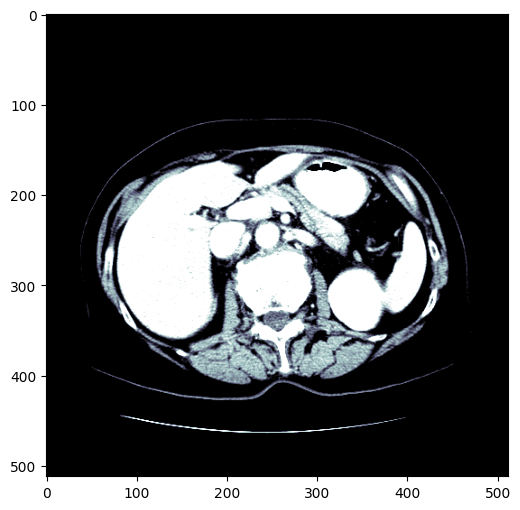

In [11]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# Data Augmentation w/ TorchIO

In [4]:
# Install necessary libraries. run only once
!pip install torchio==0.18.90 --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-image --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt
!curl -s -o slice_7t.jpg https://www.statnews.com/wp-content/uploads/2019/08/x961_unsmoothed_cropped-copy-768x553.jpg
!curl -s -o slice_histo.jpg https://upload.wikimedia.org/wikipedia/commons/6/64/Medulloepithelioma_Histology.jpg
!curl -s -o vhp.zip https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Sample-Data/Six%20slices%20from%20the%20Visible%20Male.zip
!unzip -o vhp.zip > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.1 MB/s eta 0:00:00


In [13]:
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [14]:
# Put together the training set
subjects_list = []
for index, row in df_files.iterrows():
    subject_dict = {
        'ct': tio.ScalarImage(path=row['dirname'] + '/' + row['filename']),
        'mask': tio.LabelMap(path=row['mask_dirname'] + '/' + row['mask_filename'])
    }
    subjects_list.append(tio.Subject(subject_dict))

dataset = tio.SubjectsDataset(subjects_list)

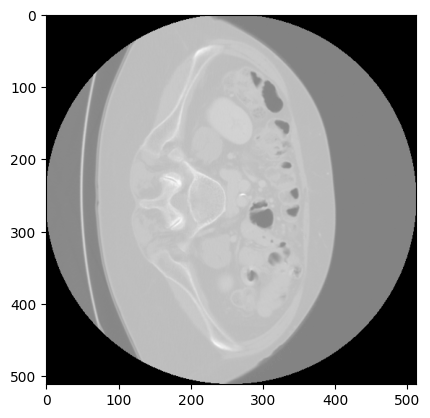

In [15]:
import matplotlib.pyplot as plt
subject = dataset[0]
ct_image_tensor = subject['ct'][tio.DATA]
ct_image_array = ct_image_tensor.numpy()
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]

plt.imshow(ct_slice, cmap='gray')
plt.show()

**Augment the dataset**

In [15]:
get_foreground = tio.ZNormalization.mean

transform = tio.Compose([
    # tio.RandomAnisotropy(p=0.25),  # make images look anisotropic 25% of times


    # tio.HistogramStandardization(
    #     landmark_location,
    #     masking_method=get_foreground),        # standardize histogram of foreground, if we can find the landmarks
    # tio.ZNormalization(
    #     masking_method=get_foreground),        # zero mean, unit variance of foreground

    tio.OneOf({
        tio.RandomBlur(p=0.25): 0.3,                    # blur 25% of times
        tio.RandomNoise(p=0.25): 0.3,                   # Gaussian noise 25% of times
        tio.ZNormalization(masking_method=get_foreground): 0.3,        # zero mean, unit variance of foreground
    }),
    # tio.RandomFlip(axes=(0, 1, 2), p=0.5),  # Random flip

    # tio.OneOf({                             # one of the spatial
    #     tio.RandomAffine(): 0.75,
    #     tio.RandomElasticDeformation(): 0.25,
    # }, p=0.8),
    # tio.RandomBiasField(p=0.3),  # Random bias field

    # tio.OneOf({
    #   tio.RandomSpike(): 0.3,  # Random spike
    #   tio.RandomGhosting(intensity=1.5): 0.3,  # Random ghosting artifact
    #   tio.RandomMotion(num_transforms=6, image_interpolation='nearest'): 0.3,  # Random motion artifact
    # }),
    tio.ToCanonical(),
    tio.Resample((1,1,1), image_interpolation='nearest'),
    tio.CropOrPad((350, 350, 350)),
])

transform_resize = tio.Compose([
  tio.ToCanonical(),
  tio.Resample((1,1,1), image_interpolation='nearest'),
  tio.CropOrPad((350, 350, 350)),
])

#indices_to_remove = [3,6,29,36,74,75,77,78,79]
augmented_dataset = tio.SubjectsDataset(subjects_list[0:3], transform=transform) + tio.SubjectsDataset(subjects_list[4:6], transform=transform) + tio.SubjectsDataset(subjects_list[7:29], transform=transform) + tio.SubjectsDataset(subjects_list[30:36], transform=transform) + tio.SubjectsDataset(subjects_list[37:74], transform=transform) + tio.SubjectsDataset([subjects_list[76]], transform=transform) + tio.SubjectsDataset(subjects_list[80:100], transform=transform)
# augmented_dataset = tio.SubjectsDataset(subjects_list[:100], transform=transform_resize) + augmented_dataset_1

val_dataset = tio.SubjectsDataset(subjects_list[100:], transform=transform_resize)

**Save Augmented Data**

In [16]:
import os
augmented_data_dir = "/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)"
os.makedirs(augmented_data_dir, exist_ok=True)

In [17]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(augmented_dataset, file)

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_val.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(val_dataset, file)

# Training and Test Datasets

**Load the Data**

In [5]:
import torch
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [6]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)


In [8]:
# i = -1
# data = []
# while i < len(augmented_dataset):
#   i += 1
#   try:
#     subject = augmented_dataset[i]
#     ct_image_tensor = subject['ct'][tio.DATA]
#     ct_mask_tensor = subject['mask'][tio.DATA]
#     if ct_image_tensor.shape == torch.Size([1, 350, 350, 350]) and ct_mask_tensor.shape == torch.Size([1, 350, 350, 350]):
#       data.append(tio.Subject(subject))
#     print(i)
#   except:
#     print("Fail")

# augmented_data = tio.SubjectsDataset(data)
# file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(augmented_data, file)

0
1
2
Fail
4
5
Fail
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Fail
30
31
32
33
34
35
Fail
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
Fail
Fail
76
Fail
Fail
Fail
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Fail


In [33]:
print(len(augmented_dataset))

91


In [ ]:
for subject in augmented_dataset:
  if 'path' in subject['ct'].keys() or 'path' in subject['mask'].keys():
    del subject['ct'].path
    del subject['mask'].path
  try:
    print(subject['ct'].path)
    print(subject['mask'].path)
  except:
    print('remove path')

remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path
remove path


In [36]:
# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_nopath.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(augmented_dataset, file)

In [38]:
# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_nopath.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)

/content/drive/My Drive/EC523Project/SegmentationData/segmentations/segmentation-1.nii


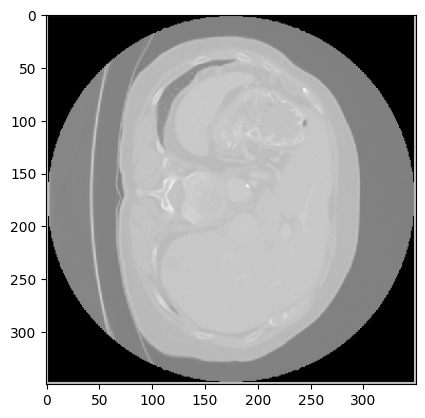

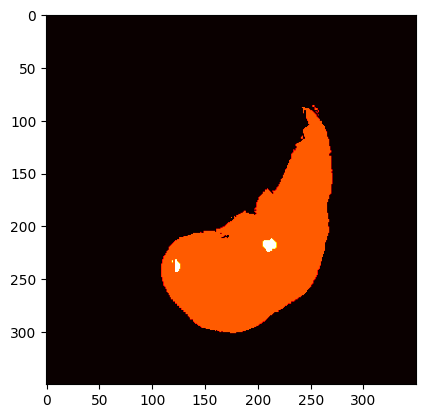

In [39]:
import matplotlib.pyplot as plt

subject = augmented_dataset[1]
# print(type(subject))

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]
ct_mask_tensor = subject['mask'][tio.DATA]

print(subject['mask'].path)
# print(ct_mask_tensor.shape)

# Convert the tensor to a NumPy array
ct_image_array = ct_image_tensor.numpy()
ct_mask_array = ct_mask_tensor.numpy()

# Select a 2D slice from the 3D CT image to display
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]
ct_slice2 = ct_mask_array[0, :, :, ct_mask_array.shape[3] // 2]

# Display the slice using Matplotlib
plt.imshow(ct_slice, cmap='gray')
plt.show()
plt.imshow(ct_slice2, cmap='hot')
plt.show()


# UNet++

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#basic block for unet++
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, padding=1)
        self.bt1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, 3, padding=1)
        self.bt2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bt1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bt2(out)
        out = self.relu(out)
        return out

class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, rates):
        super(ASPPModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[0], dilation=rates[0])
        self.atrous_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[1], dilation=rates[1])
        self.atrous_conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[2], dilation=rates[2])
        self.image_pool = nn.AdaptiveAvgPool2d(1)
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.atrous_conv1(x)
        x3 = self.atrous_conv2(x)
        x4 = self.atrous_conv3(x)
        x5 = self.image_pool(x)
        x5 = self.image_conv(x5)
        x5 = nn.functional.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=False)
        out = torch.cat([x1, x2, x3, x4, x5], dim=1)
        return out

class UNet_ASPP(nn.Module):
    def __init__(self, num_classes, in_channels, deep_supervision, **kwargs):
        super().__init__()
        self.deep_supervision = deep_supervision
        # out_channels = [32, 64, 128, 256, 512]
        out_channels = [288, 288*2, 288*4, 288*8, 288*16]

        #backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        #skip pathways
        #each conv: input = previous conv + lower conv, output = previous conv
        self.conv0_1 = ConvBlock(out_channels[0]+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1]+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2]+out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3]+out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2+out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3+out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4+out_channels[1], out_channels[0], out_channels[0])

        #pooling and up_sampling
        self.pool = nn.MaxPool2d(2, 2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        #ASPP module
        aspp_in_channels = out_channels[4]
        aspp_out_channels = out_channels[4]
        aspp_rates = [6, 12, 18]
        self.aspp = ASPPModule(aspp_in_channels, aspp_out_channels, aspp_rates)

        #deep_supervision=True: accurate mode
        #False: fast mode
        if self.deep_supervision:
            self.ds1 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.ds2 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.ds3 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
            self.ds4 = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)
        else:
            self.ds = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        #backbone
        x = x.float()
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # input = previous conv + up_sample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv0_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))

        # x0_1 = self.conv0_1(x0_0)
        # x1_1 = self.conv1_1(x1_0)
        # x2_1 = self.conv2_1(x2_0)
        # x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        # x0_2 = self.conv0_2(x0_1)
        # x1_2 = self.conv1_2(x1_1)
        # x2_2 = self.conv2_2(torch.cat([x2_1, self.up_sample(x3_1)], 1))

        # x0_3 = self.conv0_3(x0_2)
        # x1_3 = self.conv0_3(torch.cat([x1_2, self.up_sample(x2_2)], 1))

        # x0_4 = self.conv0_4(torch.cat([x0_3, self.up_sample(x1_3)], 1))

        #ASPP module
        aspp_out = self.aspp(x4_0)

        if self.deep_supervision:
            out1 = self.ds1(x0_1)
            out2 = self.ds2(x0_2)
            out3 = self.ds3(x0_3)
            out4 = self.ds4(x0_4)
            return [out1, out2, out3, out4, aspp_out]

        else:
            out = self.ds(x0_4)
            return out

# Loss

In [22]:
!pip install torch torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.0 MB/s eta 0:00:00


In [23]:
#dice loss definition
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module): #just set this as the criterion, like criterion = DiceLoss()
  def __init__(self):
    super(DiceLoss, self).__init__()

  def forward(self, input, target):
    smooth=1e-5 #this is just to avoid divide by 0
    input_flat = input.view(-1) #flatten input
    target_flat = target.view(-1) #flatten true labels
    intersection = (input_flat*target_flat).sum()
    return 1 - ((2.0*intersection+smooth)/(input_flat.sum()+target_flat.sum()+smooth))

# Training and Testing

In [24]:
loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=4, shuffle=True)

In [25]:
#training and testing functions
import torchmetrics
from torchmetrics.functional.detection import intersection_over_union
import torch.optim as optim

def train_model(model, train_loader, num_epochs, optimizer, criterion, device):
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for batch_idx, batch in enumerate(train_loader):
      inputs, labels = batch['ct']['data'][:, :, :, batch['ct']['data'].shape[3] // 2].to(device), batch['mask']['data'][:, :, :, batch['mask']['data'].shape[3] // 2].to(device)
      optimizer.zero_grad()
      if model.deep_supervision:
        out1, out2, out3, out4 = model(inputs)
        loss = criterion(out1, labels) + criterion(out2, labels) + criterion(out3, labels) + criterion(out4, labels)
      else:
        out = model(inputs)
        loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        iou_val = intersection_over_union(out, labels)
        total_iou += iou_val.item()

      total_loss += loss.item()
      if batch % 100 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch+1, len(train_loader), loss.item(), iou_val.item()))
    average_loss = total_loss/len(train_loader)
    average_iou = total_iou/len(train_loader)
    print('Epoch [{}/{}], Average Loss: {:.4f}, Average IoU: {:.4f}'
          .format(epoch+1, num_epochs, average_loss, average_iou))

def test_model(model, val_loader, criterion):
  model.eval()
  total_loss = 0.0
  total_iou = 0.0
  with torch.no_grad():
    for batch, (inputs, labels) in enumerate(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      if model.deep_supervision:
        out1, out2, out3, out4 = model(inputs)
        loss = criterion(out1, labels) + criterion(out2, labels) + criterion(out3, labels) + criterion(out4, labels)
      else:
        out = model(inputs)
        loss = criterion(out, labels)
      iou_val = intersection_over_union(out, labels)
      total_iou += iou_val.item()
      total_loss += loss.item()
    average_loss = total_loss/len(val_loader)
    average_iou = total_iou/len(val_loader)
    print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [26]:
#train the model
input_channels = 1 #change
num_classes = 2 #change
model = UNet_ASPP(num_classes, input_channels, deep_supervision=False) #can change deep_supervision
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #can change optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 10
train_model(model, loader, num_epochs, optimizer, criterion, device)

OutOfMemoryError: ignored

In [ ]:
#test the model
test_model(model, val_loader, criterion)